In [47]:
import pandas as pd
from darts import TimeSeries
from darts.models import XGBModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [48]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [49]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [50]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 16)]
    xgb_params = {
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.03204910598309296,
        'min_child_weight': 6,
        'subsample': 0.6,
        'colsample_bytree': 0.8,
        'gamma': 0.0,
        'reg_alpha': 1.88047545015871774e-05,
        'reg_lambda': 0.1811980297044638,
        'n_jobs': -1
    }

    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)

    model = XGBModel(
        lags=target_lags_list,
        output_chunk_length=1,
        add_encoders=encoders,
        **xgb_params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )
    
    forecasts = model.historical_forecasts(
        val_scaled,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.37928
[1]	validation_0-rmse:0.37138
[2]	validation_0-rmse:0.36379
[3]	validation_0-rmse:0.35661
[4]	validation_0-rmse:0.34965
[5]	validation_0-rmse:0.34304
[6]	validation_0-rmse:0.33650
[7]	validation_0-rmse:0.33027
[8]	validation_0-rmse:0.32431
[9]	validation_0-rmse:0.31878
[10]	validation_0-rmse:0.31338
[11]	validation_0-rmse:0.30781
[12]	validation_0-rmse:0.30262
[13]	validation_0-rmse:0.29769
[14]	validation_0-rmse:0.29311
[15]	validation_0-rmse:0.28845
[16]	validation_0-rmse:0.28404
[17]	validation_0-rmse:0.27978
[18]	validation_0-rmse:0.27568
[19]	validation_0-rmse:0.27179
[20]	validation_0-rmse:0.26813
[21]	validation_0-rmse:0.26446
[22]	validation_0-rmse:0.26107
[23]	validation_0-rmse:0.25782
[24]	validation_0-rmse:0.25476
[25]	validation_0-rmse:0.25159
[26]	validation_0-rmse:0.24855
[27]	validation_0-rmse:0.24577
[28]	validation_0-rmse:0.24324
[29]	validation_0-rmse:0.24

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:20.40105
[1]	validation_0-rmse:20.39551
[2]	validation_0-rmse:20.39011
[3]	validation_0-rmse:20.38509
[4]	validation_0-rmse:20.38010
[5]	validation_0-rmse:20.37533
[6]	validation_0-rmse:20.37065
[7]	validation_0-rmse:20.36613
[8]	validation_0-rmse:20.36176
[9]	validation_0-rmse:20.35933
[10]	validation_0-rmse:20.35532
[11]	validation_0-rmse:20.35142
[12]	validation_0-rmse:20.34773
[13]	validation_0-rmse:20.34404
[14]	validation_0-rmse:20.34036
[15]	validation_0-rmse:20.33687
[16]	validation_0-rmse:20.33522
[17]	validation_0-rmse:20.33188
[18]	validation_0-rmse:20.32866
[19]	validation_0-rmse:20.32564
[20]	validation_0-rmse:20.32262
[21]	validation_0-rmse:20.31970
[22]	validation_0-rmse:20.31694
[23]	validation_0-rmse:20.31420
[24]	validation_0-rmse:20.31288
[25]	validation_0-rmse:20.31038
[26]	validation_0-rmse:20.30787
[27]	validation_0-rmse:20.30546
[28]	validation_0-rmse:20.30432
[29]	validation_0-rmse:20.30307
[30]	validation_0-rmse:20.30089
[31]	validation_0-

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.



Fold 3

Treinando o modelo...
Train set: 3119 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:0.37729
[1]	validation_0-rmse:0.36525
[2]	validation_0-rmse:0.35370
[3]	validation_0-rmse:0.34244
[4]	validation_0-rmse:0.33163
[5]	validation_0-rmse:0.32109
[6]	validation_0-rmse:0.31105
[7]	validation_0-rmse:0.30125
[8]	validation_0-rmse:0.29173
[9]	validation_0-rmse:0.28258
[10]	validation_0-rmse:0.27362
[11]	validation_0-rmse:0.26495
[12]	validation_0-rmse:0.25667
[13]	validation_0-rmse:0.24847
[14]	validation_0-rmse:0.24063
[15]	validation_0-rmse:0.23303
[16]	validation_0-rmse:0.22561
[17]	validation_0-rmse:0.21852
[18]	validation_0-rmse:0.21162
[19]	validation_0-rmse:0.20506
[20]	validation_0-rmse:0.19866
[21]	validation_0-rmse:0.19243
[22]	validation_0-rmse:0.18637
[23]	validation_0-rmse:0.18097
[24]	validation_0-rmse:0.17552
[25]	validation_0-rmse:0.16996
[26]	validation_0-rmse:0.16463
[27]	validation_0-rmse:0.15957
[28]	validation_0-rmse:0.15468
[29]	validation_0-rmse:0.15023
[30]	validation_0-rmse:0.14553
[31]	validation_0-rmse:0.14105
[32]	validation_0-

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:0.39991
[1]	validation_0-rmse:0.38769
[2]	validation_0-rmse:0.37574
[3]	validation_0-rmse:0.36427
[4]	validation_0-rmse:0.35310
[5]	validation_0-rmse:0.34229
[6]	validation_0-rmse:0.33181
[7]	validation_0-rmse:0.32173
[8]	validation_0-rmse:0.31175
[9]	validation_0-rmse:0.30221
[10]	validation_0-rmse:0.29303
[11]	validation_0-rmse:0.28415
[12]	validation_0-rmse:0.27558
[13]	validation_0-rmse:0.26724
[14]	validation_0-rmse:0.25913
[15]	validation_0-rmse:0.25125
[16]	validation_0-rmse:0.24370
[17]	validation_0-rmse:0.23636
[18]	validation_0-rmse:0.22933
[19]	validation_0-rmse:0.22255
[20]	validation_0-rmse:0.21597
[21]	validation_0-rmse:0.20955
[22]	validation_0-rmse:0.20336
[23]	validation_0-rmse:0.19737
[24]	validation_0-rmse:0.19160
[25]	validation_0-rmse:0.18593
[26]	validation_0-rmse:0.18051
[27]	validation_0-rmse:0.17517
[28]	validation_0-rmse:0.17013
[29]	validation_0-rmse:0.16524
[30]	validation_0-rmse:0.16046
[31]	validation_0-rmse:0.15582
[32]	validation_0-

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 5

Treinando o modelo...
Train set: 5195 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.39205
[1]	validation_0-rmse:0.37996
[2]	validation_0-rmse:0.36830
[3]	validation_0-rmse:0.35706
[4]	validation_0-rmse:0.34603
[5]	validation_0-rmse:0.33536
[6]	validation_0-rmse:0.32508
[7]	validation_0-rmse:0.31521
[8]	validation_0-rmse:0.30550
[9]	validation_0-rmse:0.29607
[10]	validation_0-rmse:0.28704
[11]	validation_0-rmse:0.27837
[12]	validation_0-rmse:0.26973
[13]	validation_0-rmse:0.26163
[14]	validation_0-rmse:0.25374
[15]	validation_0-rmse:0.24584
[16]	validation_0-rmse:0.23819
[17]	validation_0-rmse:0.23113
[18]	validation_0-rmse:0.22398
[19]	validation_0-rmse:0.21706
[20]	validation_0-rmse:0.21056
[21]	validation_0-rmse:0.20402
[22]	validation_0-rmse:0.19775
[23]	validation_0-rmse:0.19181
[24]	validation_0-rmse:0.18588
[25]	validation_0-rmse:0.18023
[26]	validation_0-rmse:0.17473
[27]	validation_0-rmse:0.16956
[28]	validation_0-rmse:0.16443
[29]	validation_0-rmse:0.15

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


[0]	validation_0-rmse:0.38509
[1]	validation_0-rmse:0.37465
[2]	validation_0-rmse:0.36482
[3]	validation_0-rmse:0.35534
[4]	validation_0-rmse:0.34601
[5]	validation_0-rmse:0.33690
[6]	validation_0-rmse:0.32835
[7]	validation_0-rmse:0.32012
[8]	validation_0-rmse:0.31240
[9]	validation_0-rmse:0.30475
[10]	validation_0-rmse:0.29736
[11]	validation_0-rmse:0.29036
[12]	validation_0-rmse:0.28374
[13]	validation_0-rmse:0.27736
[14]	validation_0-rmse:0.27103
[15]	validation_0-rmse:0.26491
[16]	validation_0-rmse:0.25913
[17]	validation_0-rmse:0.25362
[18]	validation_0-rmse:0.24819
[19]	validation_0-rmse:0.24325
[20]	validation_0-rmse:0.23843
[21]	validation_0-rmse:0.23388
[22]	validation_0-rmse:0.22953
[23]	validation_0-rmse:0.22537
[24]	validation_0-rmse:0.22122
[25]	validation_0-rmse:0.21725
[26]	validation_0-rmse:0.21334
[27]	validation_0-rmse:0.20976
[28]	validation_0-rmse:0.20626
[29]	validation_0-rmse:0.20302
[30]	validation_0-rmse:0.19991
[31]	validation_0-rmse:0.19704
[32]	validation_0-

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 7

Treinando o modelo...
Train set: 7271 samples
Validation set: 1038 samples
[0]	validation_0-rmse:0.33399
[1]	validation_0-rmse:0.32559
[2]	validation_0-rmse:0.31739
[3]	validation_0-rmse:0.30945
[4]	validation_0-rmse:0.30192
[5]	validation_0-rmse:0.29466
[6]	validation_0-rmse:0.28754
[7]	validation_0-rmse:0.28087
[8]	validation_0-rmse:0.27452
[9]	validation_0-rmse:0.26839
[10]	validation_0-rmse:0.26257
[11]	validation_0-rmse:0.25690
[12]	validation_0-rmse:0.25153
[13]	validation_0-rmse:0.24633
[14]	validation_0-rmse:0.24151
[15]	validation_0-rmse:0.23684
[16]	validation_0-rmse:0.23227
[17]	validation_0-rmse:0.22785
[18]	validation_0-rmse:0.22359
[19]	validation_0-rmse:0.21955
[20]	validation_0-rmse:0.21579
[21]	validation_0-rmse:0.21213
[22]	validation_0-rmse:0.20880
[23]	validation_0-rmse:0.20556
[24]	validation_0-rmse:0.20245
[25]	validation_0-rmse:0.19970
[26]	validation_0-rmse:0.19678
[27]	validation_0-rmse:0.19407
[28]	validation_0-rmse:0.19159
[29]	validation_0-rmse:0.18

In [52]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


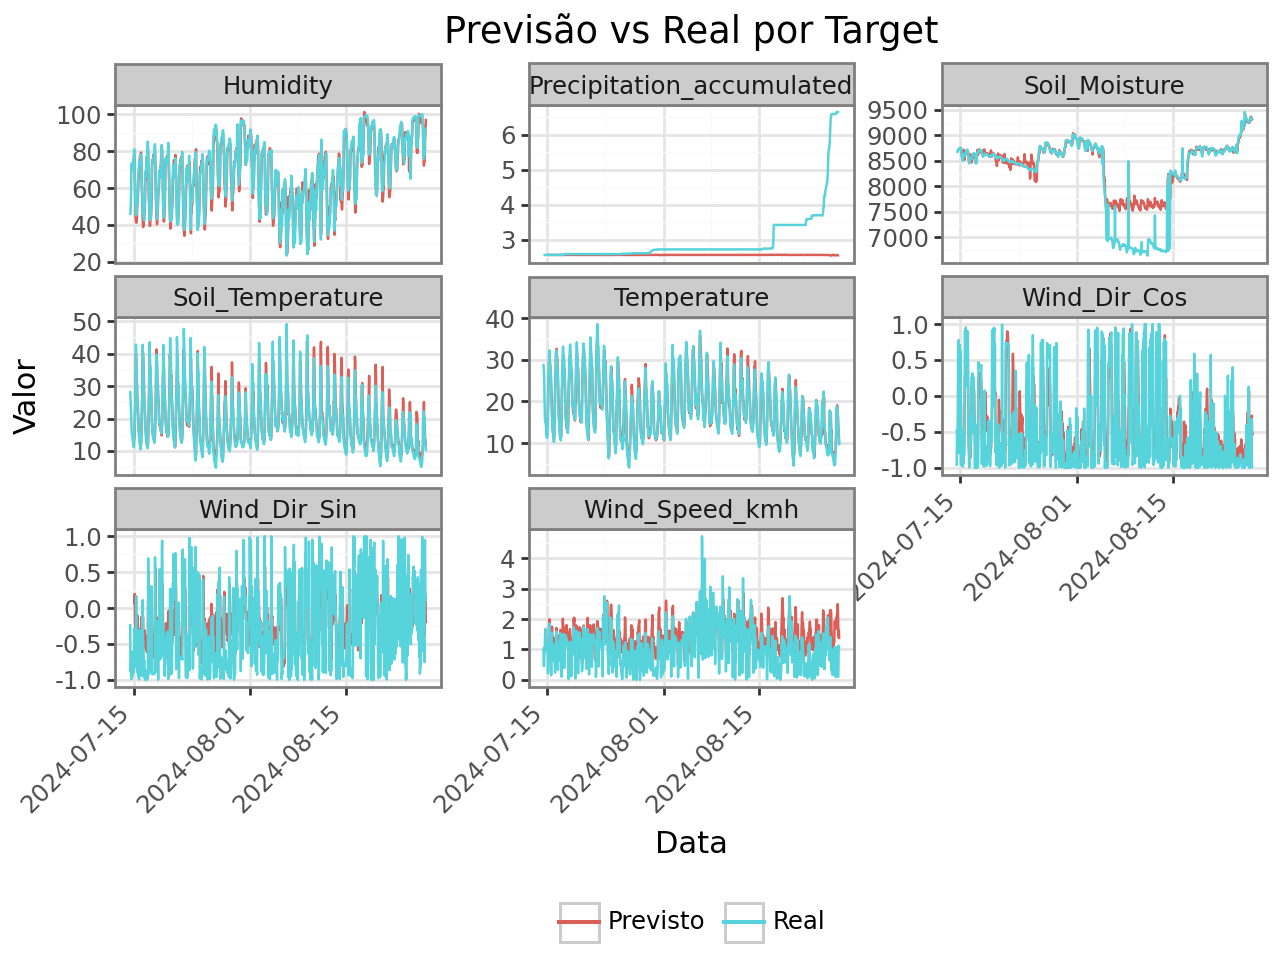

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [53]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [54]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

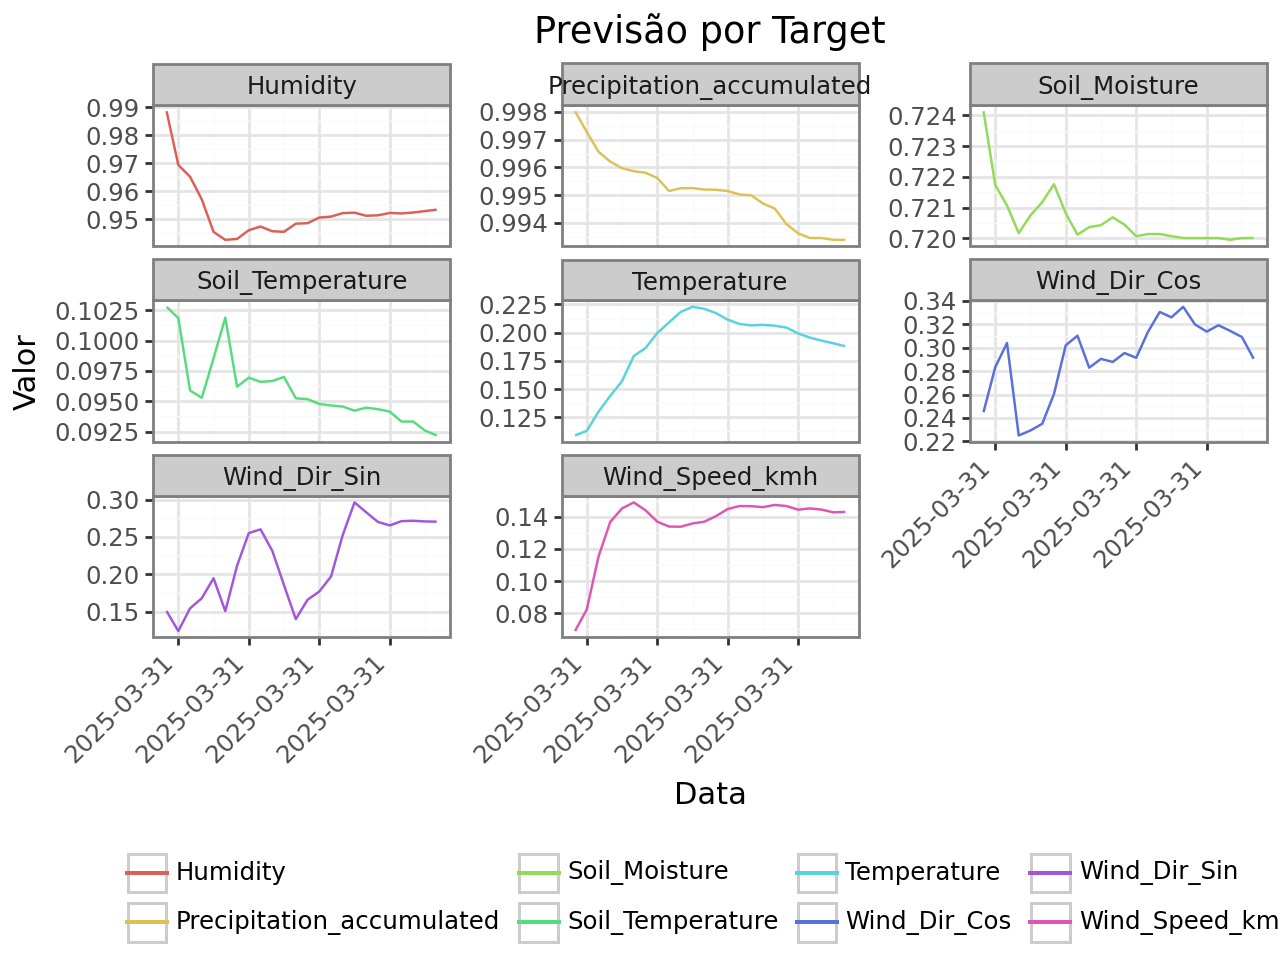

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [55]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [56]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)